# Identify Factors that Predict Intro CS Experience Based on Gender: Part Two


In [1]:
from IPython.display import display
from IPython.display import HTML
import IPython.core.display as di # Example: di.display_html('<h3>%s:</h3>' % str, raw=True)

# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# This line will add a button to toggle visibility of code blocks, for use with the HTML export version
di.display_html('''<button onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Toggle code</button>''', raw=True)


Toggle code

### Problem Statement
I am interested in identify the leading indicators of experience broken down by gender in introductory CS at an elite research university like Berkeley. In short, I want to find the attributes that split the dataset as *purely* as possible into male and female.

To solve this problem, I will undertake the following course of action:
1. Explore the dataset
    - Usually, I would explore the dataset to ensure its integrity and understand the context. But in this case, I will skip this step since I designed the study and collected the data, as such, I am well versed of the context. Further, I have done previous work on this dataset, so I know its boundaries.
2. Identify features that may be used. 
    - If possible, engineer features that might provide greater discrimination.
3. With the understanding that this a **classification** task, explore a couple of classifiers that might be well suited for the problem at hand.
    - Random Forest classifier
    - eXtreme Gradient Boosted (XGBoost) trees classifier
    - Support Vector Machine (SVM)
    - Decision Tree classifier
4.  Select appropriate classifier based on evaluation metric and tune it for optimality.
5.  Extract top features responsible for discriminating the data.

I have already completed steps one and two in this [notebook](https://github.com/omoju/genderCSExperience/blob/master/genderedCSExperience.ipynb). Now I will focus on steps three through five.


## Preliminaries

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
# Import libraries
from __future__ import division
import sys
sys.path.append('tools/')

import numpy as np
import pandas as pd
import pickle
import tools

   
# Graphing Libraries
import matplotlib.pyplot as pyplt
import seaborn as sns
sns.set_style("white")    

## Load Data

In [4]:
X = pd.read_pickle('data/features.pickle.dat')
y = pd.read_pickle('data/labels.pickle.dat')

In [5]:
# First, decide how many training vs test samples you want
num_all = X.shape[0]  # same as len(student_data)
num_train = 662  # about 75% of the data
num_test = num_all - num_train

In [6]:
from sklearn import cross_validation
def shuffle_split_data(X, y):
    """ Shuffles and splits data into 75% training and 25% testing subsets,
        then returns the training and testing subsets. """
    X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, 
                                                                        train_size=num_train, random_state=42)
    
    # Return the training and testing data subsets
    return X_train, y_train, X_test, y_test

In [7]:
# Split the data into training and testing sets

try:
    X_train, y_train, X_test, y_test = shuffle_split_data(X, y)
    print "Successfully shuffled and split the data!"
except:
    print "Something went wrong with shuffling and splitting the data."


print "Training set: {} samples".format(X_train.shape[0])
print "Test set: {} samples".format(X_test.shape[0])


Successfully shuffled and split the data!
Training set: 662 samples
Test set: 220 samples


## 3. Modeling and Validating

### Algorithms and Techniques

For the problem of determining the factors that predict intro CS experience based on gender, I experimented with four different classifiers, a decision tree classifier, two ensemble methods and a support vector machine:

- I selected a **Random Forest classifier** because it is considered one of the best off-the-shelf learning algorithm, and requires almost no tuning. 

- I selected an **eXtreme Gradient Boosted (XGBoost) trees classifier**; which is an advanced implementation of the gradient boosting algorithm. From reading literature on machine learning in practice, the XGBoost classifier has differentiated itself as a classifier that has successfully demonstrated its performance in a wide range of problems. For example, "among the 29 challenge winning solutions published at Kaggle's blog during 2015, 17 solutions used XGBoost."

- I selected a **Support Vector Machine (SVMs)** because they are very robust classifiers and *more importantly*, they have a method to correct for class imbalances. 
              
- Finally I selected a **Decision Tree classifier** because it lends itself to interpretability. For this problem domain, it is not just satisfactory for me to discriminate between male and female students, what I ultimately want is to gain *insights* into what the salient factors around the experience of intro CS are, based on gender.

I implemented the four learning algorithms. For each of the learners I implemented the baseline algorithm using a stratified shuffle split cross validation with 10 folds and calculated the F1 scores and looked at the confusion matrices respectively.


### Train Classifiers

In [8]:
X = X_train # Training data
seed = 342 # For reproducability
folds = 10

In [9]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.cross_validation import StratifiedKFold
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn import metrics


models = {
          'XGBoost': XGBClassifier(),
          'DecisionTree': DecisionTreeClassifier(),
          'SVC': svm.SVC(),
          'RandomForest': RandomForestClassifier()
         }


In [10]:
print "CLASSIFICATION RESULTS OF BASELINE CLASSIFIERS\n"
print"{:20}{:^15}{:^10}".format('CLASSIFIER', 'MEAN SCORE %', 'STD DEV %')


for model_name, model in models.iteritems():
    kfold = StratifiedKFold(y_train, n_folds=folds, random_state=np.random.seed(seed))
    results = cross_val_score(model, X, y_train, cv=kfold, scoring='f1')
    print"{:20}{:^15.2f}{:^10.2f}".format(model_name, results.mean()*100, results.std()*100)  

CLASSIFICATION RESULTS OF BASELINE CLASSIFIERS

CLASSIFIER           MEAN SCORE %  STD DEV % 
RandomForest             54.93        5.37   
DecisionTree             51.08       10.93   
XGBoost                  59.69        6.02   
SVC                      55.39        6.67   


In [11]:
Features_test = X_test
pred_results = {}


for model_name, model in models.iteritems():
    # make predictions for test data
    model.fit(X, y_train)
    y_predictions = model.predict(Features_test)
    predictions = [round(value) for value in y_predictions]
    
    # evaluate predictions
    C = confusion_matrix(y_test, predictions)
    pred_results[model_name] = dict(score=metrics.f1_score(y_test, predictions) * 100,
                              C=C, expected_value=0, rates=[[0,0],[0,0]]) 
    
    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, predictions)
    roc_auc = auc(fpr, tpr)
    pred_results[model_name]['fpr'] = fpr
    pred_results[model_name]['tpr'] = tpr
    pred_results[model_name]['roc_auc'] = roc_auc
    

### Prediction and Expected Value



In [12]:
# calculate expected rates

for key in pred_results:
    rates = tools.expected_rates(pred_results[key]['C'])
    pred_results[key]['rates'] = [[1-rates['fpr'], rates['fpr']],[1-rates['tpr'], rates['tpr']]]

In [13]:
cost_benefit_matrix = [[1, -1],[-2, 5]]

# calculate expected value
for key in pred_results:
    pred_results[key]['expected_value'] = 0
    for i in range(2):
        for j in range(2):
            pred_results[key]['expected_value'] += pred_results[key]['rates'][i][j] * cost_benefit_matrix[i][j]
            
        

In [14]:
print "{:^50}".format("PREDICTION RESULTS OF BASELINE CLASSIFIERS\n")
print"{:20}{:^15}{:^15}".format('CLASSIFIER', 'SCORE %', 'EXPECTED VALUE')
print"{:20}{:^15.2f}{:^15.2f}".format('Majority', y_train.tolist().count(0) / len(y_train) * 100, 0)
for key in pred_results:
    print"{:20}{:^15.2f}{:^15.2f}".format(key, pred_results[key]['score'], pred_results[key]['expected_value'])
    

sns.set(font_scale = 1)    
for key in pred_results:    
    tools.show_confusion_matrix(pred_results[key]['C'], 
                                key,'report/figures/'+key+'.png', ['Class Male', 'Class Female'])

   PREDICTION RESULTS OF BASELINE CLASSIFIERS
    
CLASSIFIER              SCORE %    EXPECTED VALUE 
Majority                 58.01          0.00      
RandomForest             55.91          1.87      
XGBoost                  70.35          3.11      
DecisionTree             62.44          2.63      
SVC                      53.57          1.63      


In [15]:
i, lw = 0, 2
colors = ["salmon", "k", "m", "r", "c"]
for key in pred_results:
    pyplt.plot(pred_results[key]['fpr'], pred_results[key]['tpr'], color=colors[i], lw=lw, 
               label= key+' curve %0.2f' % pred_results[key]['roc_auc'])    
    i += 1

pyplt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
pyplt.xlim([0.0, 1.0])
pyplt.ylim([0.0, 1.05])
pyplt.title("ROC Curves")
pyplt.xlabel('False Positive Rate')
pyplt.ylabel('True Positive Rate')
pyplt.legend(loc="lower right");
pyplt.savefig('report/figures/rocCurve.png', format='png', dpi=200)
pyplt.close()

## 4. Select Best Classifier

### Benchmark
Before I start selecting which classifier I want to proceed with, I need a **baseline** score on which I can evaluate the practical value of datamining for this problem. Since this project is applying machine learning to a novel dataset, I do not have standard benchmarks I can measure against. As such, I have decided to use a simple *majority* classifier which always selects the majority class of the training set. 


|Confusion Matrices|
|---|---|
| <img src="report/figures/XGBoost.png" alt="Drawing" style="width: 350px;"/>  | <img src="report/figures/SVC.png" alt="Drawing" style="width: 350px;"/> |
| <img src="report/figures/DecisionTree.png" alt="Drawing" style="width: 350px;"/>  | <img src="report/figures/RandomForest.png" alt="Drawing" style="width: 350px;"/> |

#### Expected Value

To evaluate the performance of the classifiers I consider two separate evaluation metrics, the **F_1** score of the classifiers and the **expected value**. In short, the expected value is the expected rates multiplied by the cost-benefit of each entry in the confusion matrix, weighted by the class priors. I invented a cost and benefits value associated with entry of the confusion matrix based on domain knowledge. My goal is to reward correct female class classification while penalizing false classifications. My choices for these values can be see in table below.

|Cost and Benefits|Value|
|---|---|
|Benefit of *correctly identifying* a **female** student  | 5  |
|Benefit of *correctly identifying* a **male** student  | 1  |
|Cost of *misclassifying* a **female** student  | -2  |
|Cost of *misclassifying* a **male** student  | 1  |


I am using these two evaluation metrics in tandem because simple accuracy does not distinguish between **false positive** and **false negative** rates. 

From running these baseline classifiers, I selected the **xgboost classifier** as the best classifier based on my evaluation criteria. On this problem, Random Forest classifier and the Support Vector Machine did not give a better performance than the *majority* classifier. While the Decision Tree did well, it was not as robust as the XGBoost classifier.

#### ROC Curve

<img src="report/figures/rocCurve.png" alt="Drawing" style="width: 500px;"/>
Its interesting to note that the Decision Tree classifier, had the highest true positive rate at 0.63, however, its false positive rate was a staggering 0.38! This means that it cannot find a meaningful sets of conditions for separating males from females in the dataset. The Support Vector Machine had the lowest false positive rate but did not beat the majority classifier because its true positive rate was abysmal. Where as, XGBoost does satisfactory on both fronts. You can really see this from looking at the ROC curves of the classifiers.

In [16]:
model = XGBClassifier()
model.fit(X, y_train)
    
    
g = xgb.to_graphviz(model, num_trees=1, rankdir='TB')
g.format = 'png'
g.render('report/figures/firstXGraph', view=False)
g = xgb.to_graphviz(model, num_trees=2, rankdir='TB')
g.format = 'png'
g.render('report/figures/SecondXGraph', view=False)

'report/figures/SecondXGraph.png'

In [17]:
sns.set(font_scale = 1.5)

importances = model.booster().get_fscore()
importance_frame = pd.DataFrame({'Importance': list(importances.values()), 'Feature': list(importances.keys())})
importance_frame.sort_values(by = 'Importance', inplace = True)
importance_frame.plot(kind = 'barh', x = 'Feature', figsize = (8,14),  color = 'orange');
pyplt.title('XGBOOST FEATURE IMPORTANCE')
pyplt.savefig('report/figures/featureImportance.png', dpi=200, bbox_inches='tight')
pyplt.close()


## 4. Tune Xgboost Model

I am going to tune my model based on some heuristics about the kinds of value ranges that are suitable for the hyper-parameters I want to learn.

#### Ideal choices of parameters as taken from Xgboost With Python ebook
- Number of Trees (`n_estimators`) set to a fixed value between 100 and 1000, depending on the dataset size.
- Learning Rate (`learnin_rate`) simplified to the ratio: [2 to 10]/trees, depending on the number of trees.
- Row Sampling (`subsample`) grid searched values in the range [0.5, 0.75, 1.0].
- Column Sampling (`colsample` bytree and maybe colsample bylevel) grid searched values in the range [0.4, 0.6, 0.8, 1.0].
- Min Leaf Weight (`min_child_weight`) simplified to the ratio 3/rare_events , where rare events rare events is the percentage of rare event observations in the dataset.
- Tree Size (`max_depth`) grid searched values in the rage [4, 6, 8, 10].
- Min Split Gain (`gamma`) fixed with a value of zero.


In [18]:
from sklearn.grid_search import GridSearchCV



# Build a stratified shuffle object because of unbalanced data
ssscv = StratifiedShuffleSplit(y_train, folds, random_state=np.random.seed(seed))

num_trees = range(200, 1100, 100)
params_grid = {
            'learning_rate': [x/y for x in range(2, 3, 1) for y in num_trees],
            'max_depth':  [4, 6, 8, 10, 12],
            'n_estimators': num_trees,
            'colsample_bytree': [0.4, 0.6, 0.8, 1.0],
            'subsample':[0.7]
}

params_fixed = {
    'objective': 'binary:logistic',
    'silent': 1
}

In [19]:
# Load and use already tuned classifier, else tune classifier

tune_flag = False
model_filename = "data/fixedDepthTree.pickle.dat"
hyper_params = ['n_estimators', 'subsample', 'learning_rate', 'colsample_bytree', 'max_depth']

if tune_flag:
    grid = GridSearchCV(estimator=XGBClassifier(**params_fixed),
        param_grid=params_grid,
        cv=ssscv,
        scoring='f1')
    grid.fit(X, y_train)
    
    print "Best accuracy obtained: {0}".format(grid.best_score_)
    print "Parameters:"
    for key, value in grid.best_params_.items():
        print "\t{}: {}".format(key, value)
    model = grid.best_estimator_
    
    # save model to file
    pickle.dump(model, open(model_filename, "wb"))
    print "MODEL HYPER-PARAMETERS\n"
    for item in hyper_params:
        print "{:16}: {:<10.2f}".format(item, model.get_params()[item])
   
    
else:    
    model = tools.load_model(model_filename)
    print "TUNED MODEL HYPER-PARAMETERS\n"
    for item in hyper_params:
        print "{:16}: {:<10.2f}".format(item, model.get_params()[item])
   
   
    

TUNED MODEL HYPER-PARAMETERS

n_estimators    : 900.00    
subsample       : 0.70      
learning_rate   : 0.01      
colsample_bytree: 1.00      
max_depth       : 6.00      


In [20]:
Features_test = X_test

# make predictions for test data
model.fit(X, y_train)
ypred = model.predict(Features_test)
predictions = ypred

# evaluate predictions
xgb_tuned_prediction_score = f1_score(y_test, predictions) * 100

print "Prediction of tuned classifier: %.2f%%"%(xgb_tuned_prediction_score)
print "Tuned Model improvement over baseline classifier: %.2f%%"%(xgb_tuned_prediction_score - 
                                                                  pred_results['XGBoost']['score'])

Prediction of tuned classifier: 73.17%
Tuned Model improvement over baseline classifier: 2.82%


In [21]:
sns.set(font_scale = 1)
model_name = model.__class__.__name__

C = confusion_matrix(y_test, ypred)
tools.show_confusion_matrix(C, model_name, 'report/figures/tuned_model_CM.png', ['Class Male', 'Class Female'])

In [22]:
model.fit(X, y_train)
g = xgb.to_graphviz(model, num_trees=1, rankdir='TB')
g.format = 'png'
g.render('report/figures/first_tuned_model_graph', view=False)

g = xgb.to_graphviz(model, num_trees=2, rankdir='TB')
g.format = 'png'
g.render('report/figures/second_tuned_model_graph', view=False)

'report/figures/second_tuned_model_graph.png'

### Results of tuning
Once I performed the search through the hyper-parameter space to find the combination of hyper-parameters that maximized the performance of the selected classifier, I was able to **improve** the previous `F_1` score **by 2.82%**, to achieve a prediction score of 73.17%.
- You can see that the **false negative** count for the female class has gone from 40 down to 35. This decision cost us a very small increase in the **false positive** count of the male class from 19 to 20. This is not too bad, so I will stick with this improved model.

| **Base Model** | **Tuned Model** |
|---|---|
| <img src="report/figures/XGBoost.png" alt="Drawing" style="width: 350px;"/>  | <img src="report/figures/tuned_model_CM.png" alt="Drawing" style="width: 350px;"/> |

## Identifying the important factors 
To idenitfy factors that predict experience based on gender, I will then extract the top features responsible for discriminating the data and then expand the final step to:
- Explore the various parameters around feature splitting 
    - Xgboost algorithm feature importance score
    - Information gain
    - Cover
    

### Feature Importance: Xgboost 
There are two things that need consideration when using xgBoost for understanding feature importance: the features that are doing the *most* work in splitting the data, and the automatically generated feature importance ranking that is done in xgBoost.

#### Base Model Trees
I plotted some estimators in the xgboost learners to see which features are doing the most work in splitting the data. I chose to focus on the **first** and **second** tree in the ensemble. On simple models, the first two trees may be enough to gain a *strong* understanding. This model has three levels and eight distinct types.

| **First tree in the ensemble** | **Second tree in the ensemble** |
|---|---|
| <img src="report/figures/firstXGraph.png" alt="Drawing" style="width: 500px;"/>  | <img src="report/figures/secondXGraph.png" alt="Drawing" style="width: 500px;"/> |

#### Tuned Model Trees
The tuned model has a more complex tree that goes down six levels, for each of its estimators. This model segmented the data into 36 distinct types; you can see this by counting the number of leaf nodes.

#### First tree in the esemble
![tuned tree](report/figures/first_tuned_model_graph.png)


#### Second tree in the esemble
![tuned tree](report/figures/second_tuned_model_graph.png)

## 5(a). Feature Importance: Tuned Model

In [23]:
params_dict = model.get_params()
xgdmat = xgb.DMatrix(X, y_train) # Create our DMatrix to make XGBoost more efficient
testdmat = xgb.DMatrix(X_test)

cv_xgb = xgb.cv(params = params_dict, dtrain = xgdmat, num_boost_round = 3000, nfold = folds,
                metrics =['map'],
                early_stopping_rounds = 100) # Look for early stopping that minimizes error


Will train until cv error hasn't decreased in 100 rounds.
Stopping. Best iteration: 251


In [24]:
bst = xgb.train(params_dict, xgdmat, num_boost_round = 251)
y_pred = bst.predict(testdmat,ntree_limit=bst.best_ntree_limit)

In [25]:
# evaluate predictions
y_pred[y_pred > 0.5] = 1
y_pred[y_pred <= 0.5] = 0


In [33]:
sns.set(font_scale = 1.5)

importances = bst.get_fscore()
df_1 = pd.DataFrame({'Importance': list(importances.values()), 'Feature': list(importances.keys())})
df_1.sort_values(by = 'Importance', inplace = True)
df_1.plot(kind = 'barh', x = 'Feature', figsize = (8,14));
pyplt.title('XGBOOST TUNED FEATURE IMPORTANCE\n')
pyplt.savefig('report/figures/featureImportance_tuned.png', dpi=200, bbox_inches='tight')
pyplt.close()


## 5(b). Feature Importance: Information Gain based Ranking 
One can think on **information gain** as a measurement of *informativeness* of a feature with respect to the target class.

In [27]:
tools.create_feature_map(list(importances.keys()),'data/xgb_model_feature_map.txt')

In [28]:
information_gain_list = tools.order_features_by_gains(bst, 'data/xgb_model_feature_map.txt')

In [99]:
importances_gain = {}
for i in range(len(information_gain_list)):
    feat, info = information_gain_list[i]
    importances_gain[feat] = round(info['gain'])


In [100]:
sns.set(font_scale = 1.5)
df_2 = pd.DataFrame({'Gain': list(importances_gain.values()), 'Feature': list(importances_gain.keys())})
df_2.sort_values(by = 'Gain', inplace = True)
df_2.plot(kind = 'barh', x = 'Feature', figsize = (8,14), color = 'green');
pyplt.title('INFORMATION-GAIN BASED FEATURE IMPORTANCE\n')
pyplt.savefig('report/figures/featureImportance_informationGain.png', dpi=200, bbox_inches='tight')
pyplt.close()

## 5(c). Feature Importance: Cover based Ranking 

The cover is the sum of second order gradient in each node, and intuitively it represents the number of data points affected by the split.

In [101]:
importances_cover = {}
for i in range(len(information_gain_list)):
    feat, info = information_gain_list[i]
    importances_cover[feat] = round(info['cover'])

In [102]:
sns.set(font_scale = 1.5)
df_3 = pd.DataFrame({'Cover': list(importances_cover.values()), 'Feature': list(importances_cover.keys())})
df_3.sort_values(by = 'Cover', inplace = True)
df_3.plot(kind = 'barh', x = 'Feature', figsize = (8,14), color = 'grey');
pyplt.title('COVER BASED FEATURE IMPORTANCE\n')
pyplt.savefig('report/figures/featureImportance_cover.png', dpi=200, bbox_inches='tight')
pyplt.close()

## Results

| **XGBoost Generated Feature Importance (1)** | **Information Gain Based Feature Importance (2)** | **Cover Based Feature Importance (3)** |
|---|---|---|
| <img src="report/figures/featureImportance_tuned.png" alt="Drawing" style="width: 350px;"/>  | <img src="report/figures/featureImportance_informationGain.png" alt="Drawing" style="width: 350px;"/>  | <img src="report/figures/featureImportance_cover.png" alt="Drawing" style="width: 350px;"/> |

As you can see, these three approaches gave three separate answers. I will use an ad-hoc method based on the following outline to determine which factors are the most pertinent.

1. Select the first 20 features
2. Triangulate between the three approaches and select only features that are common to all three.

In [134]:
dfd_1 = df_1[20:]
dfd_2 = df_2[20:]
dfd_3 = df_3[20:]

df = pd.merge(dfd_1, dfd_2, on='Feature')
df = pd.merge(df, dfd_3, on='Feature')
df.sort_values(['Importance'], ascending=False, inplace = True)
df = df.reset_index(drop=True)
df

,Feature,Importance,Gain,Cover
0,atcsgender_2,424,710.0,3724.0
1,atcsjob_2,395,862.0,6162.0
2,clet_2,330,1041.0,4466.0
3,atcsgender_3,285,469.0,2003.0
4,atct_5,273,835.0,5462.0
5,blg_1,260,1103.0,4777.0
6,blg_4,255,755.0,3898.0
7,atcs_4,242,1285.0,6295.0
8,clet_1,217,1098.0,6181.0
9,priorcs10,212,1482.0,8833.0


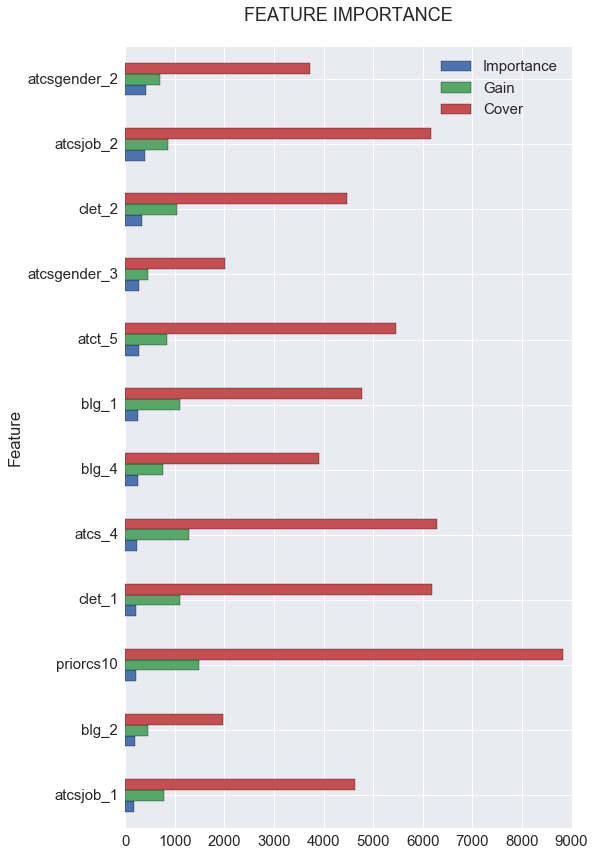

In [140]:
df.sort_values(by = 'Importance', inplace = True)
df.plot(kind = 'barh', x = 'Feature', figsize = (8,14));
pyplt.title('FEATURE IMPORTANCE\n')
pyplt.savefig('report/figures/final_importance.png', dpi=200, bbox_inches='tight')